Epoch 10, Train Loss: 0.0194, Validation Loss: 0.0247
Epoch 20, Train Loss: 0.0138, Validation Loss: 0.0217
Epoch 30, Train Loss: 0.0116, Validation Loss: 0.0195
Epoch 40, Train Loss: 0.0097, Validation Loss: 0.0173
Epoch 50, Train Loss: 0.0089, Validation Loss: 0.0155
Epoch 60, Train Loss: 0.0081, Validation Loss: 0.0164
Epoch 70, Train Loss: 0.0061, Validation Loss: 0.0107
Epoch 80, Train Loss: 0.0058, Validation Loss: 0.0110
Epoch 90, Train Loss: 0.0047, Validation Loss: 0.0098
Epoch 100, Train Loss: 0.0049, Validation Loss: 0.0107
Epoch 110, Train Loss: 0.0047, Validation Loss: 0.0101
Epoch 120, Train Loss: 0.0046, Validation Loss: 0.0097
Epoch 130, Train Loss: 0.0042, Validation Loss: 0.0118
Epoch 140, Train Loss: 0.0042, Validation Loss: 0.0097
Epoch 150, Train Loss: 0.0044, Validation Loss: 0.0097
Epoch 160, Train Loss: 0.0040, Validation Loss: 0.0096
Epoch 170, Train Loss: 0.0037, Validation Loss: 0.0100
Epoch 180, Train Loss: 0.0037, Validation Loss: 0.0098
Epoch 190, Train Lo

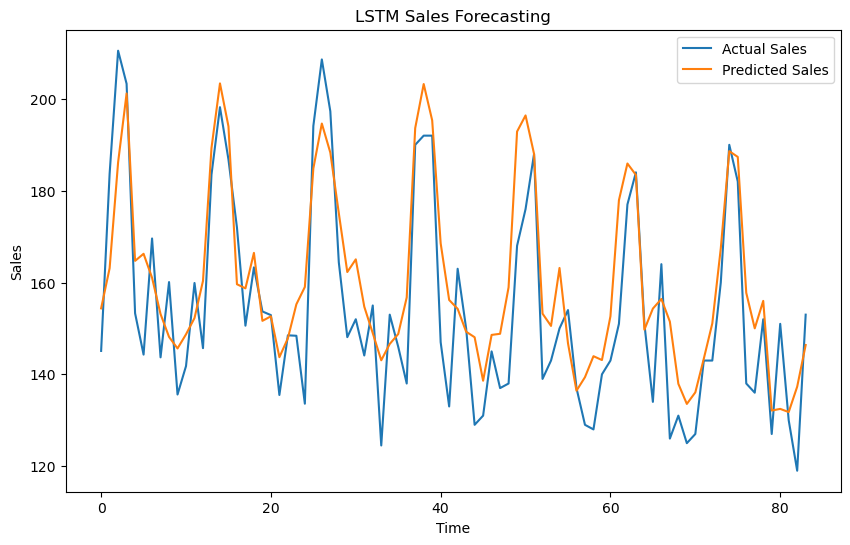

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

# Load data
data = pd.read_csv('datasets_56102_107707_monthly-beer-production-in-austr.csv',index_col=0,parse_dates=True)
sales = data.values.reshape(-1, 1)

# Define the sizes for train (60%), validation (20%), and test (20%) splits
train_size = int(0.6 * len(sales))
val_size = int(0.2 * len(sales))
test_size = len(sales) - train_size - val_size

# Preprocess data: normalize the sales data
scaler = MinMaxScaler()
scaler.fit(sales[:train_size])
sales_scaled = scaler.transform(sales)

# Create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Set sequence length
seq_length = 12  # Using 12 months of data to predict the next month

# Create sequences and targets
X, y = create_sequences(sales_scaled, seq_length)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)



# Chronologically split the data
train_data = TensorDataset(X_tensor[:train_size], y_tensor[:train_size])
val_data = TensorDataset(X_tensor[train_size:train_size + val_size], y_tensor[train_size:train_size + val_size])
test_data = TensorDataset(X_tensor[train_size + val_size:], y_tensor[train_size + val_size:])


# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Initialize the model, loss function, and optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Validation Loss: {val_loss/len(val_loader):.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=200)

# Testing and visualization
def test_and_visualize(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            predictions.append(output.numpy())
            actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    # Rescale predictions and actuals back to original scale
    predictions_rescaled = scaler.inverse_transform(predictions)
    actuals_rescaled = scaler.inverse_transform(actuals)

    # Plot results
    plt.figure(figsize=(10,6))
    plt.plot(actuals_rescaled, label='Actual Sales')
    plt.plot(predictions_rescaled, label='Predicted Sales')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title('LSTM Sales Forecasting')
    plt.legend()
    plt.show()

# Test and visualize
test_and_visualize(model, test_loader)
